In [1]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install s3fs
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re
import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

import keras
from keras.utils import np_utils
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge
from keras.layers import Input, Dense, Activation, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import s3fs

import time
import datetime
from data_helpers_v6 import load_data, clean_str, text_preprocessing, label_processing, evaluation, ints2setences
from tensorflow.contrib import learn
import tensorflow as tf

# data preparation --------------------------------------------

NUM_SUMPLE = 6000
MAX_LEN_DOC = 70
MAX_NB_WORDS = 200000
URL1 = 's3://smart-newsdev-dmp/tmp/data/classification/data_handlabeling_cycle2/train.csv'
URL2 = 's3://smart-newsdev-dmp/tmp/data/classification/data_handlabeling_cycle2/test.csv'
TEXT_TITLE_COMBINED = True

x, y, split_index, vocab_size, id2word, word2id, pre_x, pre_data, labelEncoder = load_data(
    MAX_LEN_DOC=MAX_LEN_DOC, NUM_SUMPLE=NUM_SUMPLE, MAX_NB_WORDS=MAX_NB_WORDS,
    url1=URL1, url2=URL2, TEXT_TITLE_COMBINED=TEXT_TITLE_COMBINED)

pre_x_train, pre_x_test = pre_x.iloc[0:split_index], pre_x.iloc[split_index:]
x_train, x_test, y_train, y_test = x[0:split_index], x[split_index:], y[0:split_index], y[split_index:]

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


Loading data...
Clean up texts...
Tokenizing...
Integer encoding...
Padding...
('x_train shape:', (7864, 70))
('x_test shape:', (1966, 70))


In [2]:
embeddings_index = {}
f = open('../word_vector/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [3]:
# parameters --------------------------------------------------

sequence_length = x_train.shape[1]
vocabulary_size = vocab_size
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5
num_class = y_train.shape[1]
embedding_dim = 100
epochs = 10
batch_size = 32
# --------------------------------------------------------------

print("Creating Model...")
# TO DO --- store the model in function

embedding_matrix = np.zeros((len(word2id) + 1, embedding_dim))
for word, i in word2id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, 
                      output_dim=embedding_dim,
                      weights = [embedding_matrix], #### use pre-trained word vector
                      trainable = False,  #### use pre-trained word vector
                      input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=num_class, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# try categorical_crossentropy?

print("Traning Model...")
history = model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
# should have store this in history
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

Creating Model...
Traning Model...
Train on 7077 samples, validate on 787 samples
Epoch 1/10
7077/7077 [==============================] - 38s 5ms/step - loss: 2.4371 - acc: 0.2425 - val_loss: 1.1613 - val_acc: 0.7421
Epoch 2/10
7077/7077 [==============================] - 38s 5ms/step - loss: 1.4819 - acc: 0.4903 - val_loss: 0.8170 - val_acc: 0.7942
Epoch 3/10
7077/7077 [==============================] - 39s 5ms/step - loss: 1.0826 - acc: 0.6336 - val_loss: 0.6569 - val_acc: 0.8310
Epoch 4/10
7077/7077 [==============================] - 38s 5ms/step - loss: 0.8689 - acc: 0.7126 - val_loss: 0.5928 - val_acc: 0.8297
Epoch 5/10
7077/7077 [==============================] - 38s 5ms/step - loss: 0.7223 - acc: 0.7650 - val_loss: 0.5471 - val_acc: 0.8374
Epoch 6/10
7077/7077 [==============================] - 38s 5ms/step - loss: 0.6457 - acc: 0.7923 - val_loss: 0.5245 - val_acc: 0.8323
Epoch 7/10
7077/7077 [==============================] - 38s 5ms/step - loss: 0.5687 - acc: 0.8159 - val_loss

In [4]:
# evaluate the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 84.69%


In [5]:
def check_sample(pre_x, post_x, sampl_num, id2word):
#     print ('\n{} Original x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_x.iloc[sampl_num])
#     print ('\n{} Original title #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_df['title'].iloc[sampl_num])
#     print ('\n{} Original text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_df['text'].iloc[sampl_num])
#     print ('\n{} Processed x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (post_x[sampl_num])
    print ('\n{} Reverted x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
    print (ints2setences(post_x[sampl_num], id2word))

def error_analysis(y_pred, y_test, pre_x, post_x, id2word, num_errors):
    for item in np.where(y_pred != y_test):
        for i, idx in enumerate (item):
            if i < num_errors:
                print("----------------------------idx {}, prediction {}, test {} ----------------------------------".format(
                    idx, y_pred[idx], y_test[idx]))
                print ("prediction----{}".format(labelEncoder.inverse_transform(y_pred)[idx]))
                print ("test----------{}".format(labelEncoder.inverse_transform(y_test)[idx]))
                print("---"*30)
                print (check_sample(pre_x=pre_x, post_x=post_x, sampl_num=idx, id2word=id2word))

---------Confusion Matrix Report -------------------- 

[[104   2   7   3   2   1   1  15   7]
 [  1 198   8   4   3   1   5   3   6]
 [  2  15  99   8   4  11   2   8   4]
 [  2   2   7 135   7   6   3   3   6]
 [  4   6   5   9 195   0   2   1   6]
 [  0   0  10   2   0 244   0   2   2]
 [  2   2   2   3   0   1 282   1   0]
 [  7   4   7   3   0   5   0 194   4]
 [  5   5   7  19   9   4   2   1 214]]

---------Classificaiton Report ---------------------- 

                     precision    recall  f1-score   support

     EN_US_BUSINESS       0.82      0.73      0.77       142
EN_US_ENTERTAINMENT       0.85      0.86      0.86       229
    EN_US_LIFESTYLE       0.65      0.65      0.65       153
     EN_US_NATIONAL       0.73      0.79      0.76       171
     EN_US_POLITICS       0.89      0.86      0.87       228
      EN_US_SCIENCE       0.89      0.94      0.92       260
       EN_US_SPORTS       0.95      0.96      0.96       293
   EN_US_TECHNOLOGY       0.85      0.87      

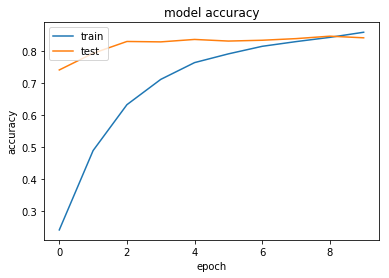

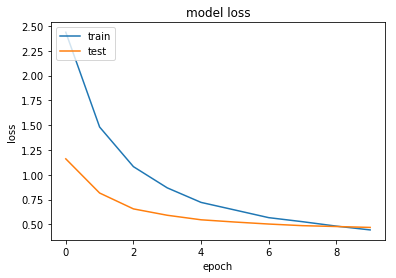

----------------------------idx 0, prediction 2, test 3 ----------------------------------
prediction----EN_US_LIFESTYLE
test----------EN_US_NATIONAL
------------------------------------------------------------------------------------------

------------------------------ Reverted x_text #0 ------------------------------

the affordable care act who was helped most nytimes com the affordable care act who was helped most change in insured americans 2013 14 we know that about 10 million more people have insurance coverage this year as a result of the affordable care act but until now it has been difficult to say much about who was getting that coverage where they live their age their income and other
None
----------------------------idx 7, prediction 8, test 4 ----------------------------------
prediction----EN_US_WORLD
test----------EN_US_POLITICS
------------------------------------------------------------------------------------------

------------------------------ Reverted x_text #7

In [6]:
y_pred = model.predict(x_test)
evaluation(y_pred=y_pred.argmax(-1), y_test=y_test.argmax(-1), history=history, labelEncoder=labelEncoder)
error_analysis(y_pred.argmax(-1), y_test.argmax(-1), pre_x_test, x_test, id2word, 30)